In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

%matplotlib inline
print(tf.__version__)

2.3.1


In [2]:
data_folder = "Data"
labels_csv = "labels.csv"
folders_list = os.listdir(data_folder)
print("Total classes detected:", len(folders_list))

Total classes detected: 43


Importing Classes...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 

Here is a sample picture:


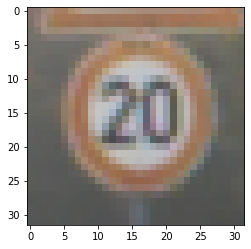

In [3]:
# 从硬盘文件夹中读取训练和测试用的图片，以文件夹的名字作为标签，同时记录每一个文件夹中的文件数目
images = []
class_num = []
pic_num = []
print('Importing Classes...')
for x in range(0, len(folders_list)):
    pic_list = os.listdir(data_folder + '/' + str(x))
    pic_num.append(len(pic_list))
    for y in pic_list:
        img = cv2.imread(data_folder + '/' + str(x) + '/' + y)
        img = cv2.resize(img, (32,32))
        images.append(img)
        class_num.append(x)
    print(x, end = " ")
    
images = np.array(images)
classes = np.array(class_num)

print('\n\nHere is a sample picture:')
plt.imshow(images[0], cmap = 'gray')
plt.show()

In [4]:
# 读取CSV，以获得类别标签
data=pd.read_csv(labels_csv)
print("data shape ",data.shape,type(data))
print(data.head())
print("ClassId has datatype: ", data['ClassId'].dtype)

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>
   ClassId                  Name
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)
ClassId has datatype:  int64


43


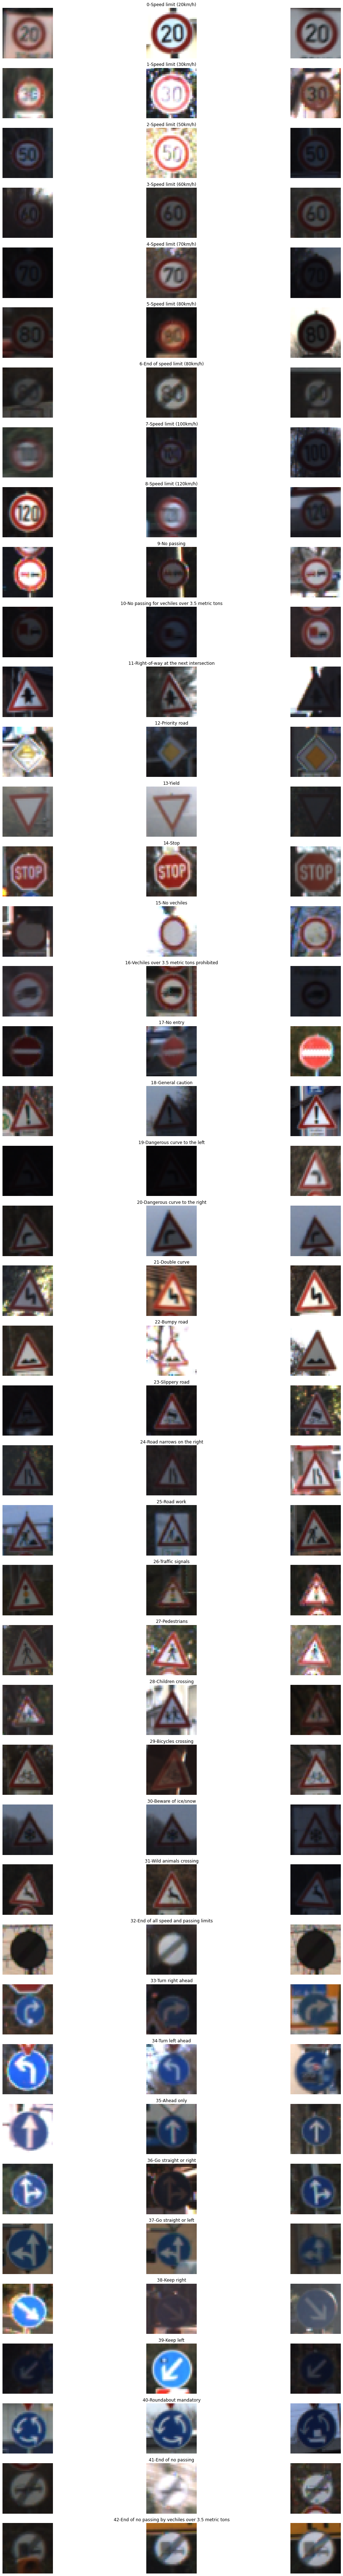

In [5]:
# 从每种类别中随机选取3帐来展示一下
cols = 3
num_classes = len(data['ClassId'])
print(num_classes)
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize = (20, 100))

for j in range(len(data['ClassId'])):
    for i in range(cols):
        img_path = random.choice(os.listdir(os.path.join(data_folder, str(j))))
        img = cv2.imread(os.path.join(data_folder, str(j), img_path))
        axs[j][i].imshow(img, cmap="gray")
        axs[j][i].axis("off")
        if i == 1:
            axs[j][i].set_title(str(j)+ "-"+ list(data['Name'])[j])

plt.tight_layout()
plt.show()

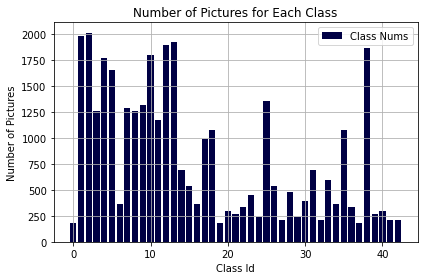

In [6]:
# 绘制每种类别中图片数目的柱状图
plt.bar(data['ClassId'], pic_num,
        color = '#000044',
        label = 'Class Nums')

plt.xlabel('Class Id')
plt.ylabel('Number of Pictures')
plt.title('Number of Pictures for Each Class')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# 设定一些训练参数
BATCH_SIZE = 32
STEPS_PER_EPOCH = 600
EPOCHS = 20
IMAGE_DIM = (32, 32, 3)
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

In [8]:
# 分类训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(images, classes, test_size=TEST_RATIO)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_RATIO)

In [9]:
# 验证一下每一个数据集中的图片和标签数目是否相等
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)
assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of lables in training set"
assert(X_validation.shape[0]==y_validation.shape[0]), "The number of images in not equal to the number of lables in validation set"
assert(X_test.shape[0]==y_test.shape[0]), "The number of images in not equal to the number of lables in test set"
assert(X_train.shape[1:]==(IMAGE_DIM))," The dimesions of the Training images are wrong "
assert(X_validation.shape[1:]==(IMAGE_DIM))," The dimesionas of the Validation images are wrong "
assert(X_test.shape[1:]==(IMAGE_DIM))," The dimesionas of the Test images are wrong"

Data Shapes
Train(25055, 32, 32, 3) (25055,)
Validation(6264, 32, 32, 3) (6264,)
Test(3480, 32, 32, 3) (3480,)


Let's see an example:


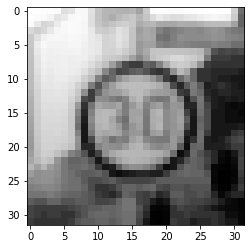

In [10]:
# 预处理图片：转为灰色调 + 直方图均衡
def Preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img

print('Let\'s see an example:')
img = Preprocessing(X_train[100])
plt.imshow(img, cmap = 'gray')
plt.show()

In [11]:
X_train = np.array(list(map(Preprocessing, X_train)))
X_test =  np.array(list(map(Preprocessing, X_test)))
X_validation = np.array(list(map(Preprocessing, X_validation)))

In [12]:
# 根据Tensorflow神经网络输入端的需要在每个图片末尾增加一个维度
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1],
                                    X_validation.shape[2], 1)

In [13]:
# 通过旋转、放大等扩充训练集
data_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    rotation_range = 10)
data_generator.fit(X_train)

In [14]:
# 获得每一个标签的一位有效编码
y_train = tf.keras.utils.to_categorical(y_train, len(folders_list))
y_test = tf.keras.utils.to_categorical(y_test, len(folders_list))
y_validation = tf.keras.utils.to_categorical(y_validation, len(folders_list))

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (5,5),
                           input_shape = (IMAGE_DIM[0], IMAGE_DIM[1], 1),
                           activation = 'relu'),
    tf.keras.layers.Conv2D(64, (5,5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(folders_list), activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0

In [16]:
# 编译模型
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [17]:
# 训练模型
history = model.fit(data_generator.flow(X_train, y_train, batch_size = BATCH_SIZE),
                    steps_per_epoch = STEPS_PER_EPOCH,
                    epochs = EPOCHS,
                    validation_data = (X_validation, y_validation),
                    shuffle = 1)

Epoch 1/20
600/600 [==============================] - 59s 98ms/step - loss: 2.9841 - accuracy: 0.1909 - val_loss: 1.6436 - val_accuracy: 0.5404
Epoch 2/20
600/600 [==============================] - 60s 100ms/step - loss: 1.8887 - accuracy: 0.4294 - val_loss: 1.0123 - val_accuracy: 0.6981
Epoch 3/20
600/600 [==============================] - 61s 101ms/step - loss: 1.4609 - accuracy: 0.5385 - val_loss: 0.6605 - val_accuracy: 0.7939
Epoch 4/20
600/600 [==============================] - 62s 103ms/step - loss: 1.1721 - accuracy: 0.6252 - val_loss: 0.5130 - val_accuracy: 0.8269
Epoch 5/20
600/600 [==============================] - 62s 104ms/step - loss: 1.0010 - accuracy: 0.6775 - val_loss: 0.3343 - val_accuracy: 0.8938
Epoch 6/20
600/600 [==============================] - 63s 104ms/step - loss: 0.8594 - accuracy: 0.7210 - val_loss: 0.2702 - val_accuracy: 0.9143
Epoch 7/20
600/600 [==============================] - 63s 105ms/step - loss: 0.7927 - accuracy: 0.7468 - val_loss: 0.2292 - val_acc

In [18]:
model.save('tf_traffic_sign')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: tf_traffic_sign/assets


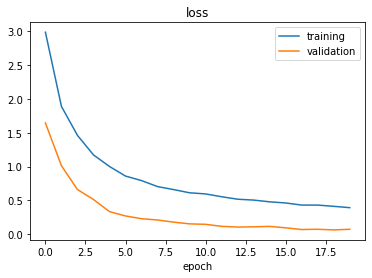

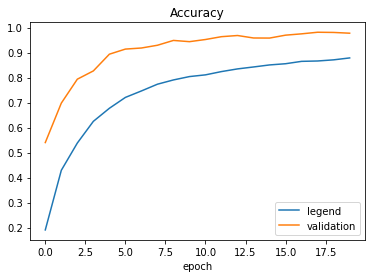

In [19]:
# 绘制训练过程中的损失与准确率图像
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['legend', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [21]:
# 在测试集上验证一下准确率
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test score = ', score[0])
print('Test accuracy = ', score[1])

Test score =  0.08772744238376617
Test accuracy =  0.9715517163276672
